In [1]:
# 数据集处理程序
import torch
import pandas as pd
from rdkit import Chem
from torch_geometric.data import Data
from tqdm import tqdm
from scipy.sparse import coo_matrix
import numpy as np
import os

def one_hot_encoding(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding


class MoleculeFeaturizer(object):
    def __init__(self, bond_features=True):
        self.bond_features = bond_features

    def _atom_featurizer(self, atom):
        atomic_numer = [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 28, 29,
                        30, 31, 32, 33, 34, 35, 36, 37, 38, 46, 47, 48, 49, 50, 51, 52, 53]
        atom_type_value = atom.GetAtomicNum()
        atom_type_features = one_hot_encoding(atom_type_value, atomic_numer)

        degree_choices = list(range(5))
        degree = atom.GetTotalDegree()
        degree_features = one_hot_encoding(degree, degree_choices)

        hybridization_choices = list(range(len(Chem.HybridizationType.names) - 1))
        hybridization = int(atom.GetHybridization())
        hybrid_features = one_hot_encoding(hybridization, hybridization_choices)

        chiral_tag_choices = list(range(len(Chem.ChiralType.names) - 1))
        chiral_tag = atom.GetChiralTag()
        chiral_tag_features = one_hot_encoding(chiral_tag, chiral_tag_choices)

        num_Hs_choices = list(range(5))
        num_Hs = atom.GetTotalNumHs()
        num_Hs_features = one_hot_encoding(num_Hs, num_Hs_choices)

        aromatic_features = [1 if atom.GetIsAromatic() else 0]

        return atom_type_features + degree_features + hybrid_features + chiral_tag_features + num_Hs_features + aromatic_features

    def _bond_featurizer(self, bond):
        bond_type = bond.GetBondType()
        bond_type_one_hot_encoding = [
            int(bond_type == Chem.rdchem.BondType.SINGLE),
            int(bond_type == Chem.rdchem.BondType.DOUBLE),
            int(bond_type == Chem.rdchem.BondType.TRIPLE),
            int(bond_type == Chem.rdchem.BondType.AROMATIC)
        ]
        addition_bond_features = [
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        return bond_type_one_hot_encoding + addition_bond_features

    def __call__(self, mol):
        self.feature_dict = {}

        # 原子特征
        atom_features = [self._atom_featurizer(atom) for atom in mol.GetAtoms()]
        self.feature_dict['x'] = atom_features

        # 边索引
        adj = Chem.GetAdjacencyMatrix(mol)
        coo_adj = coo_matrix(adj)
        edge_index = torch.tensor([coo_adj.row, coo_adj.col], dtype=torch.long)
        self.feature_dict['edge_index'] = edge_index

        # 边特征（与 edge_index 保持顺序一致）
        bond_features = []
        if self.bond_features and edge_index.size(1) > 0:
            for i, j in zip(coo_adj.row, coo_adj.col):
                bond = mol.GetBondBetweenAtoms(int(i), int(j))
                if bond is not None:
                    bond_features.append(self._bond_featurizer(bond))
                else:
                    bond_features.append([0] * 6)  # 用零向量填补无效边
        else:
            bond_features = []

        self.feature_dict['edge_attr'] = bond_features

        return self.feature_dict


class MolDataset:
    def __init__(self, csv_path, save_path='./checkpoint/processed_dataset.pt'):
        self.csv_path = csv_path
        self.save_path = save_path
        self.featurizer = MoleculeFeaturizer()
        self.data_list = []
        self._process_csv()
    
    def _process_csv(self):
        try:
            df = pd.read_csv(self.csv_path)
            print(f"Successfully loaded CSV file from {self.csv_path}")
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            return

        if not all(col in df.columns for col in ['Smiles', 'logSw']):
            print("CSV file must contain 'Smiles' and 'logSw' columns")
            return

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing molecules"):
            smiles = row['Smiles']
            label = row['logSw']

            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"Skipping invalid SMILES: {smiles}")
                continue

            try:
                features = self.featurizer(mol)

                data = Data()
                data.smiles = smiles
                data.y = torch.tensor([label], dtype=torch.float32)
                data.x = torch.tensor(features['x'], dtype=torch.float32)
                data.edge_index = features['edge_index']

                if len(features['edge_attr']) > 0:
                    data.edge_attr = torch.tensor(features['edge_attr'], dtype=torch.float32)
                else:
                    data.edge_attr = torch.empty((0, 6), dtype=torch.float32)

                self.data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule {smiles}: {e}")
                continue

        if self.data_list:
            torch.save(self.data_list, self.save_path)
            print(f"Processed dataset saved to {self.save_path}")
        else:
            print("No valid molecules processed")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

print('数据集设置完成!')

数据集设置完成!


In [2]:
# 模型定义和训练设置
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random

# 超参数
lr = 0.001
weight_decay = 1e-4
train_ratio = 0.8
batch_size = 32
epoches = 200

# 设置随机种子
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

# 初始化权重函数
def init_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# MLP模块
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers=2, dropout=0.1, activation=nn.ReLU()):
        super().__init__()
        if layers == 1:
            self.layers = nn.Linear(input_dim, output_dim)
        else:
            layer_list = []
            for i in range(layers - 1):
                layer_list.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
                layer_list.append(activation)
                layer_list.append(nn.LayerNorm(hidden_dim))
                layer_list.append(nn.Dropout(dropout))
            layer_list.append(nn.Linear(hidden_dim, output_dim))
            self.layers = nn.Sequential(*layer_list)

        self.layers.apply(init_weight)

    def forward(self, x):
        return self.layers(x)

# GAT模型 + MLP预测头
class GATNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, mlp_hidden=64, output_dim=1, heads=4, mlp_layers=2, dropout=0.1):
        super(GATNet, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout)
        self.pool = global_mean_pool
        self.mlp = MLP(input_dim=hidden_dim, hidden_dim=mlp_hidden, output_dim=output_dim,
                       layers=mlp_layers, dropout=dropout, activation=nn.ReLU())

    def forward(self, x, edge_index, batch, edge_attr=None):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)  # 使用边特征
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr=edge_attr)  # 使用边特征
        x = F.elu(x)
        x = self.pool(x, batch)
        out = self.mlp(x)
        return out.squeeze()

    def extract_graph_embeddings(self, x, edge_index, batch, edge_attr=None):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)  # 使用边特征
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr=edge_attr)  # 使用边特征
        x = F.elu(x)
        pooled = self.pool(x, batch)
        return pooled  # [num_graphs, hidden_dim]

print('模型定义完成!')


模型定义完成!


In [18]:
# 数据加载和模型初始化

# 创建保存目录
save_dir = "mol_global_features"
checkpoint_dir = "checkpoint"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

dataset = MolDataset(csv_path='./SweetpredDB.csv')

# 划分训练验证集
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

# 模型准备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU: ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}") 
model = GATNet(
    input_dim=dataset[0].x.shape[1],
    hidden_dim=64,
    mlp_hidden=64,
    output_dim=1,
    heads=4,
    mlp_layers=2,
    dropout=0.1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

print(f'数据加载完成! 数据集大小: {len(dataset)}')
print(f'训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}')
print(f'使用设备: {device}')
print(f'模型输入维度: {dataset[0].x.shape[1]}')


Successfully loaded CSV file from ./SweetpredDB.csv


Processing molecules: 100%|██████████| 627/627 [00:01<00:00, 341.57it/s]


Processed dataset saved to ./checkpoint/processed_dataset.pt
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
数据加载完成! 数据集大小: 627
训练集大小: 501, 验证集大小: 126
使用设备: cuda
模型输入维度: 69


In [19]:
# 定义训练和验证函数

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index, batch.batch, edge_attr=batch.edge_attr)  # 传递边特征
        loss = loss_fn(pred, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

# 验证函数
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch, edge_attr=batch.edge_attr)  # 传递边特征
            preds.append(pred.cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    mse = F.mse_loss(preds, labels).item()
    r2 = r2_score(labels.numpy(), preds.numpy())
    return mse, r2

# 提取图表示（全局特征）用于t-SNE
def extract_global_features(loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pooled = model.extract_graph_embeddings(batch.x, batch.edge_index, batch.batch, edge_attr=batch.edge_attr)  # 传递边特征
            all_features.append(pooled.cpu())
            all_labels.append(batch.y.cpu())
    all_features = torch.cat(all_features).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_features, all_labels

print('训练函数定义完成!')

训练函数定义完成!


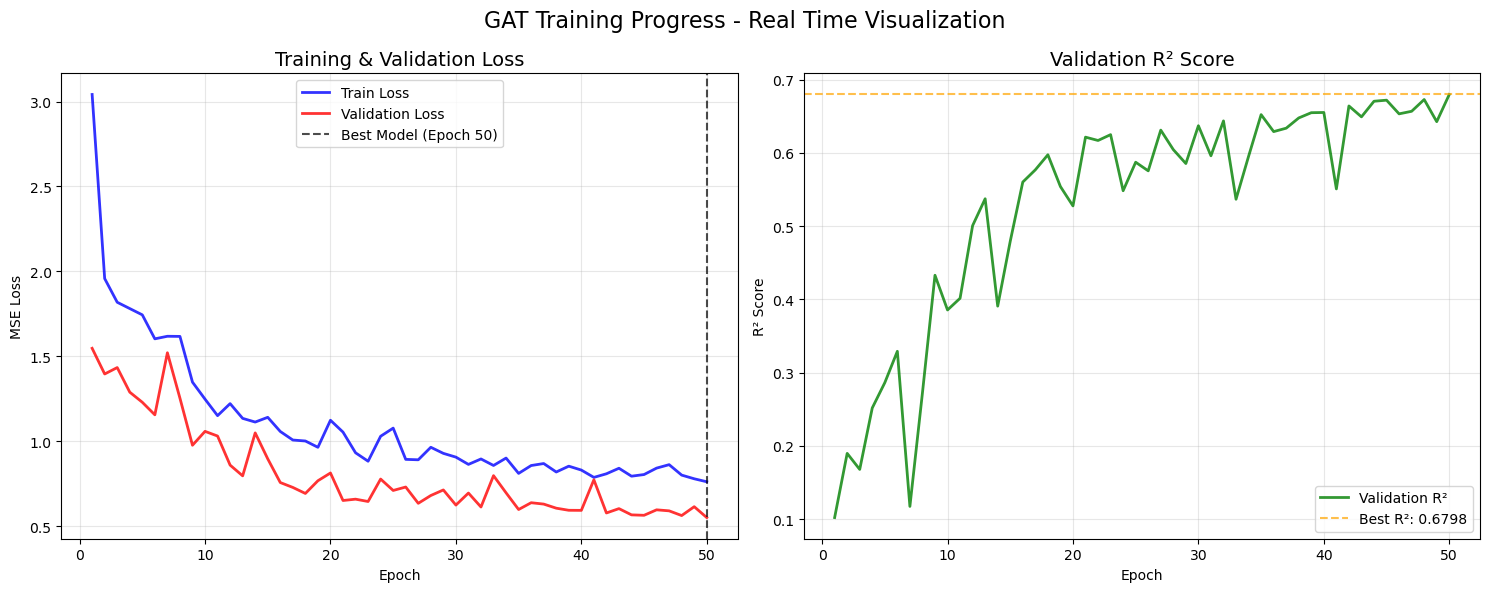

Epoch 050 | Train Loss: 0.7626 | Val MSE: 0.5519 | Val R2: 0.6798
训练完成! 最佳验证集 R²: 0.6798 (在第 50 轮)
训练进度图已保存到 checkpoint/training_progress.png
训练历史数据已保存到 checkpoint/training_history.pt


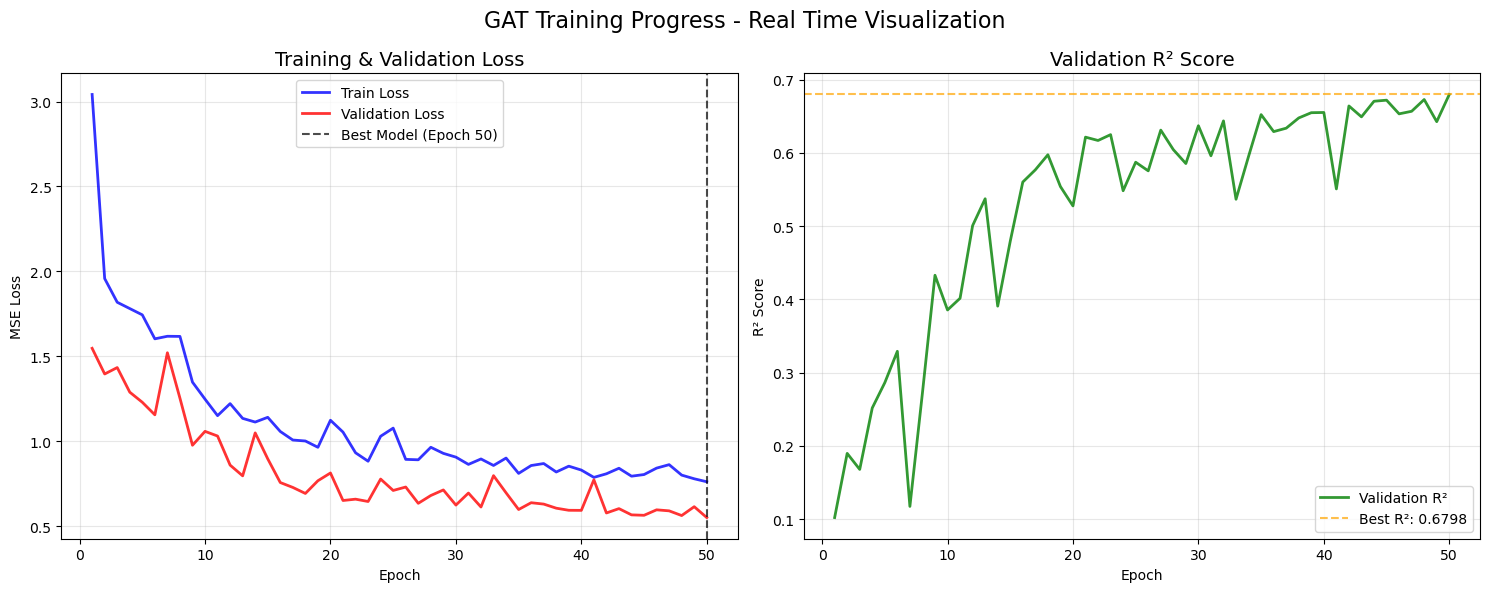

In [20]:
# 开始训练，并实时可视化训练数据
from IPython.display import clear_output, display

# 创建实时可视化图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('GAT Training Progress - Real Time Visualization', fontsize=16)

# 初始化绘图
ax1.set_title('Training & Validation Loss', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.grid(True, alpha=0.3)

ax2.set_title('Validation R² Score', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R² Score')
ax2.grid(True, alpha=0.3)

# 训练主循环 + 实时可视化
train_losses = []
val_losses = []
val_r2_scores = []
best_val_r2 = -float("inf")
best_epoch = 0

print("开始训练...")

for epoch in range(1, epoches + 1):
    train_loss = train()
    val_mse, val_r2 = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_r2_scores.append(val_r2)

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_gat_MLP_model.pt"))

    # 实时更新图表
    epochs = list(range(1, epoch + 1))
    
    # 清除并重新绘制损失图
    ax1.clear()
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
    ax1.axvline(x=best_epoch, color='black', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
    ax1.set_title('Training & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 清除并重新绘制R²图
    ax2.clear()
    ax2.plot(epochs, val_r2_scores, 'g-', label='Validation R²', linewidth=2, alpha=0.8)
    ax2.axhline(y=best_val_r2, color='orange', linestyle='--', alpha=0.7, label=f'Best R²: {best_val_r2:.4f}')
    ax2.set_title('Validation R² Score', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R² Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 在Jupyter中显示更新
    plt.tight_layout()
    clear_output(wait=True)  # 清除之前的输出
    display(fig)  # 显示当前图表

    # 保存本轮训练的图表示 + 标签
    global_feats, labels = extract_global_features(train_loader)
    np.save(os.path.join(save_dir, f"features_epoch_{epoch:03d}.npy"), global_feats)
    np.save(os.path.join(save_dir, f"labels_epoch_{epoch:03d}.npy"), labels)

    if epoch % 1 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val MSE: {val_mse:.4f} | Val R2: {val_r2:.4f}")

print(f"训练完成! 最佳验证集 R²: {best_val_r2:.4f} (在第 {best_epoch} 轮)")

# 保存最终图表
plt.savefig(os.path.join(checkpoint_dir, "training_progress.png"), dpi=300, bbox_inches='tight')
print(f"训练进度图已保存到 {checkpoint_dir}/training_progress.png")

# 保存训练历史数据
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_r2_scores': val_r2_scores,
    'best_epoch': best_epoch,
    'best_val_r2': best_val_r2
}, os.path.join(checkpoint_dir, "training_history.pt"))
print(f"训练历史数据已保存到 {checkpoint_dir}/training_history.pt")

In [24]:
# 单个预测

# 导入库，只要有.pt文件就可以随时从此往下运行
import torch

# 加载训练好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATNet(
    input_dim=69,  # 输入特征的维度（节点特征的维度）
    hidden_dim=64,
    mlp_hidden=64,
    output_dim=1,
    heads=4,
    mlp_layers=2,
    dropout=0.1
).to(device)

# 加载最佳模型权重
model.load_state_dict(torch.load("./checkpoint/best_gat_MLP_model.pt"))
model.eval()

# 辅助函数：SMILES转化为特征
def smiles_to_features(smiles, featurizer):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"无法解析SMILES: {smiles}")

    features = featurizer(mol)
    data = Data()
    data.smiles = smiles
    data.x = torch.tensor(features['x'], dtype=torch.float32).to(device)
    data.edge_index = features['edge_index'].to(device)

    if len(features['edge_attr']) > 0:
        data.edge_attr = torch.tensor(features['edge_attr'], dtype=torch.float32).to(device)
    else:
        data.edge_attr = torch.empty((0, 6), dtype=torch.float32).to(device)

    return data

# 主函数：预测甜度
def predict_sweetness(smiles, model, featurizer):
    try:
        data = smiles_to_features(smiles, featurizer)
        with torch.no_grad():
            pred = model(data.x, data.edge_index, data.batch, edge_attr=data.edge_attr)
        return pred.item()
    except Exception as e:
        print(f"错误: {e}")
        return None

# 用户输入新的SMILES
new_smiles = input("请输入化合物的SMILES字符串: ")     # 糖精：C1=CC=C2C(=C1)C(=O)NS2(=O)=O

# 创建特征提取器
featurizer = MoleculeFeaturizer()

# 预测甜度
predicted_sweetness = predict_sweetness(new_smiles, model, featurizer)

if predicted_sweetness is not None:
    print(f"预测的甜度值为: {predicted_sweetness:.4f}")

C:\Users\15274\AppData\Local\Temp\ipykernel_24428\3253468678.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoint/best_gat_MLP

请输入化合物的SMILES字符串:  CCC


预测的甜度值为: 2.6829


In [25]:
#批量预测

import torch
import pandas as pd
from torch_geometric.data import Data
from tqdm import tqdm  

# 加载训练好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATNet(
    input_dim=69,  # 输入特征的维度（节点特征的维度）
    hidden_dim=64,
    mlp_hidden=64,
    output_dim=1,
    heads=4,
    mlp_layers=2,
    dropout=0.1
).to(device)

# 加载最佳模型权重
model.load_state_dict(torch.load("./checkpoint/best_gat_MLP_model.pt"))
model.eval()

# 辅助函数：SMILES转化为特征
def smiles_to_features(smiles, featurizer):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"无法解析SMILES: {smiles}")

    features = featurizer(mol)
    data = Data()
    data.smiles = smiles
    data.x = torch.tensor(features['x'], dtype=torch.float32).to(device)
    data.edge_index = features['edge_index'].to(device)

    if len(features['edge_attr']) > 0:
        data.edge_attr = torch.tensor(features['edge_attr'], dtype=torch.float32).to(device)
    else:
        data.edge_attr = torch.empty((0, 6), dtype=torch.float32).to(device)
    return data

# 主函数：预测甜度
def predict_sweetness(smiles, model, featurizer):
    try:
        data = smiles_to_features(smiles, featurizer)
        with torch.no_grad():
            pred = model(data.x, data.edge_index, data.batch, edge_attr=data.edge_attr)
        return pred.item()
    except Exception as e:
        print(f"错误: {e}")
        return None

# 加载包含SMILES的CSV文件
csv_path = "./lipo.csv"
df = pd.read_csv(csv_path)

if 'smiles' not in df.columns:
    print("CSV文件必须包含'smiles'列！")
else:
    # 创建特征提取器
    featurizer = MoleculeFeaturizer()

    # 用于保存预测结果
    predictions = []

    # 批量预测，并且添加进度条
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Predicting Sweetness"):
        smiles = row['smiles']
        lipo = row['lipo']
        predicted_sweetness = predict_sweetness(smiles, model, featurizer)
        if predicted_sweetness is not None:
            predictions.append([smiles, predicted_sweetness, lipo])

    # 创建一个新的DataFrame来保存预测结果
    prediction_df = pd.DataFrame(predictions, columns=['smiles', 'Predicted_Sweetness', 'lipo'])

    # 打印预测结果
    print("\n预测结果：")   
    print(prediction_df)

    # 保存预测结果到CSV文件
    output_csv = "./prediction.csv"
    prediction_df.to_csv(output_csv, index=False)
    print(f"\n预测结果已保存到 {output_csv}")


C:\Users\15274\AppData\Local\Temp\ipykernel_24428\3672334172.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoint/best_gat_MLP


预测结果：
                                                 smiles  Predicted_Sweetness  \
0               Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14             4.309645   
1     COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...             4.292746   
2                COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl             3.250987   
3     OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...             4.098957   
4     Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...             4.025443   
...                                                 ...                  ...   
4195            OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1             4.553729   
4196  CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...             3.898631   
4197                                 COc1cccc2[nH]ncc12             4.537754   
4198                    Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3             4.402851   
4199                 CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N             4.378442   

      lipo  
0     3.54  
1    -

In [26]:
# 基于梯度的模型可解释性分析
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
import numpy as np
from tqdm import tqdm  

num_samples = 10       # 输出分子的个数，可调

model = GATNet(
    input_dim=69,
    hidden_dim=64,
    mlp_hidden=64,
    output_dim=1,
    heads=4,
    mlp_layers=2,
    dropout=0.1
).to(device)


def visualize_grad_heatmap(model, val_dataset, device, num_samples):    

    gradient_dir = "./gradient"
    if not os.path.exists(gradient_dir):
        os.makedirs(gradient_dir)
    
    # 随机选择样本
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    subset = torch.utils.data.Subset(val_dataset, indices)
    loader = DataLoader(subset, batch_size=1, shuffle=False)

    # 自定义颜色映射
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", [(230/255, 111/255, 81/255), "white", (138/255, 176/255, 125/255)]
    )
    model.eval()

    # 添加tqdm进度条
    for batch_idx, data in enumerate(tqdm(loader, desc="Generating heatmaps")):
        data = data.to(device)

        # 准备需要梯度的输入
        input_x = data.x.clone().detach().requires_grad_(True)
        data.x = input_x

        # 前向传播
        pred = model(data.x, data.edge_index, data.batch, edge_attr=data.edge_attr)

        # 反向传播计算梯度
        model.zero_grad()
        pred.backward()

        # 获取梯度并归一化
        grads = input_x.grad.abs().sum(dim=1).cpu().numpy()
        grads = (grads - grads.min()) / (grads.max() - grads.min() + 1e-8)

        # 获取分子对象
        mol = Chem.MolFromSmiles(data.smiles[0])
        AllChem.Compute2DCoords(mol)  # 生成2D坐标

        # 绘制热力图
        fig = SimilarityMaps.GetSimilarityMapFromWeights(
            mol,
            grads,
            colorMap=custom_cmap,
            contourLines=5,
            size=(200, 200),
            drawAtoms=False,
            coordScale=1.0,
            step=0.01
        )
        # 后处理确保无残留标签（兼容旧版本RDKit）
        for ax in fig.axes:
            for txt in ax.texts:
                txt.set_visible(False)

        plt.savefig(os.path.join(gradient_dir, f"gradient_heatmap_{batch_idx}.png"), dpi=300, bbox_inches='tight')
        plt.close()

# 使用示例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("./checkpoint/best_gat_MLP_model.pt"))  # 加载最佳模型
visualize_grad_heatmap(model, val_dataset, device, num_samples)
print('输出完成！')

C:\Users\15274\AppData\Local\Temp\ipykernel_24428\1417276066.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoint/best_gat_MLP

输出完成！
